In [1]:
import xarray as xr
import ee
import contextily as ctx
import os
from dotenv import load_dotenv
import geopandas as gpd
from me_resources.resources import get_credentials
from me_resources.object_storages import get_s3_filesystem, get_s3_client
import dask.distributed
import pandas_geojson as pdg
import pandas as pd
from geomob import create_geometry
from datetime import datetime
import datetime as dt
import numpy as np

In [2]:
zone = 'COPE' #IT, DK, ITTEST etc...
scale = 0.001
path = '/home/alessandro/RoadSample'

In [3]:
#set the credentials for the minio bucket
load_dotenv(path+'/.env')
os.environ['MINIO_ACCESS_KEY_ID']=os.getenv("access_id")
os.environ['MINIO_SECRET_ACCESS_KEY']=os.getenv("secret_key")
#create the s3 filesystem
fs = get_s3_filesystem(get_credentials('minio'))
s3 = get_s3_client(get_credentials('minio'))

In [4]:
# initialize Earth Engine:
def ee_init():
    ee.Authenticate()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

In [5]:
#initialize dask client and ee in each worker
client = dask.distributed.Client()
client.run(ee_init)
ee_init()
client

/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45317 instead
  warnings.warn(
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtr

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45317/status,
Dashboard: http://127.0.0.1:45317/status,Workers: 6
Total threads: 24,Total memory: 47.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34041,Workers: 6
Dashboard: http://127.0.0.1:45317/status,Total threads: 24
Started: Just now,Total memory: 47.04 GiB
Comm: tcp://127.0.0.1:36513,Total threads: 4
Dashboard: http://127.0.0.1:41467/status,Memory: 7.84 GiB
Nanny: tcp://127.0.0.1:35781,


[11.64064575 55.47734598 12.93220918 56.15636623]


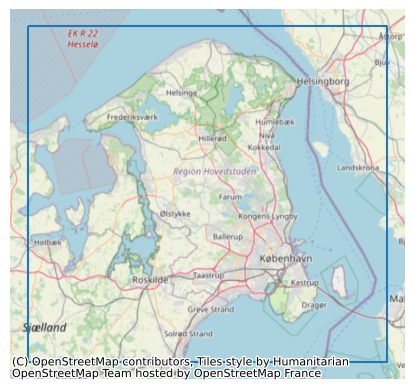

In [6]:
#read AOI
AOIdf = gpd.read_file(path+'/AOI/'+zone+'AOI.geojson')
ax = AOIdf.boundary.plot()
ax.axis('off')
ctx.add_basemap(ax,crs=AOIdf.crs.to_string())
AOI = ee.Geometry.Rectangle(*AOIdf.total_bounds)
print(AOIdf.total_bounds)

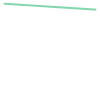

In [7]:
#import data
covariates_geojson=pdg.read_geojson(path+'/roads/mean_by_timeframe_lines.geojson')
#create geometry column from geojson features
geoms = [create_geometry(x['geometry']) for x in covariates_geojson.to_dict()['features']]
geoms[0]

In [8]:
#create geodataframe from geometries
covariates_df=covariates_geojson.to_dataframe()
covariates_df['geometry']=geoms
covariates_gdf = gpd.GeoDataFrame(covariates_df.drop(columns=['type', 'geometry.type', 'geometry.coordinates']),crs='EPSG:4326')

In [9]:
line=ee.Geometry.LineString(list(covariates_gdf.geometry[0].coords))

In [10]:
datesstr=['2023-01-01','2023-01-15', '2023-02-01', '2023-02-15', '2023-03-01', '2023-03-15', '2023-04-01', '2023-04-15', '2023-05-01', '2023-05-15', '2023-06-01', '2023-06-15', '2023-07-01', '2023-07-15', '2023-08-01', '2023-08-15', '2023-09-01', '2023-09-15', '2023-10-01', '2023-10-15', '2023-11-01', '2023-11-15', '2023-12-01', '2023-12-15']
#convert dates to datetime
datesdt = [datetime.strptime(date, '%Y-%m-%d') for date in datesstr]
datesplusone = [date + dt.timedelta(days=1) for date in datesdt]
datesplusone = [date.strftime('%Y-%m-%d') for date in datesplusone]
dates=np.stack([datesstr,datesplusone],axis=1)
dates

array([['2023-01-01', '2023-01-02'],
       ['2023-01-15', '2023-01-16'],
       ['2023-02-01', '2023-02-02'],
       ['2023-02-15', '2023-02-16'],
       ['2023-03-01', '2023-03-02'],
       ['2023-03-15', '2023-03-16'],
       ['2023-04-01', '2023-04-02'],
       ['2023-04-15', '2023-04-16'],
       ['2023-05-01', '2023-05-02'],
       ['2023-05-15', '2023-05-16'],
       ['2023-06-01', '2023-06-02'],
       ['2023-06-15', '2023-06-16'],
       ['2023-07-01', '2023-07-02'],
       ['2023-07-15', '2023-07-16'],
       ['2023-08-01', '2023-08-02'],
       ['2023-08-15', '2023-08-16'],
       ['2023-09-01', '2023-09-02'],
       ['2023-09-15', '2023-09-16'],
       ['2023-10-01', '2023-10-02'],
       ['2023-10-15', '2023-10-16'],
       ['2023-11-01', '2023-11-02'],
       ['2023-11-15', '2023-11-16'],
       ['2023-12-01', '2023-12-02'],
       ['2023-12-15', '2023-12-16']], dtype='<U10')

In [11]:
# Define the function to reduce region
def reduce_region(image,segment):
    reduced = image.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=segment,
        scale=10,  #in meters
        maxPixels=1e9
    )
    return ee.Feature(None, reduced)

In [ ]:
def sampleLines(collection,days,selectBand,line):
    # Call the function on the image collection
    radee = ee.ImageCollection(collection).filterDate(days[0], days[1]).filterBounds(AOI).select(selectBand)
    rad = radee.map(lambda image: reduce_region(image, line))
    
    # Extract the results
    results = rad.getInfo()
    features=results['features']
    sampled=pd.DataFrame(columns=['date',selectBand])
    for feature in features:
        properties = feature['properties']
        values = properties[selectBand]  
        print(values)
        valmean=np.mean(values)
        if values:
            sampled = pd.concat([sampled,pd.DataFrame({'date':feature['id'],selectBand:[valmean]})],ignore_index=True)
    
    #convert date string to datetime for each row
    sampled['date']=sampled['date'].apply(lambda x: datetime.strptime(str(x)[0:8], '%Y%m%d'))
    sampled=sampled.groupby('date').mean()
    return sampled

In [13]:
covariates_gdf['geometry']

0      LINESTRING (-4.09882 5.35319, -4.09882 5.35319...
1      LINESTRING (-4.09737 5.35111, -4.09739 5.35111...
2      LINESTRING (-4.09736 5.35053, -4.09736 5.35053...
3      LINESTRING (-4.09685 5.35053, -4.09733 5.35053...
4      LINESTRING (-4.09943 5.34699, -4.09943 5.34722...
                             ...                        
199    LINESTRING (-4.01196 5.44834, -4.01209 5.44779...
200    LINESTRING (-4.01442 5.44609, -4.01442 5.44609...
201    LINESTRING (-4.01375 5.41148, -4.01329 5.41142...
202      LINESTRING (-4.01053 5.41182, -4.00993 5.41182)
203    LINESTRING (-4.0159 5.41459, -4.01543 5.41459,...
Name: geometry, Length: 204, dtype: geometry

In [15]:
#for d in dates:
#test=sampleLines('ECMWF/ERA5_LAND/HOURLY',d, 'temperature_2m',line)
#results=covariates_gdf['geometry'].apply(lambda x: sampleLines('ECMWF/ERA5_LAND/HOURLY',dates[0], 'temperature_2m',ee.Geometry.LineString(list(x.coords))))
results=pd.DataFrame()
for row in covariates_gdf.head(30).iterrows():
    print(row[1])
    results=pd.concat([results,sampleLines('ECMWF/ERA5_LAND/HOURLY',dates[9], 'total_precipitation',ee.Geometry.LineString(list(row[1]['geometry'].coords)))])

properties.osm_id                                                    30628338
properties.code                                                        5122.0
properties.fclass                                                 residential
properties.name                                                          None
properties.t                                                        31.916667
properties.h                                                            59.25
properties.p                                                      1004.858333
properties.pm1                                                      12.490071
properties.pm25                                                     15.159208
properties.pm10                                                     17.025666
properties.voc                                                       0.049125
properties.h_10am-1pm                                               55.833333
properties.h_1pm-4pm                                            

/tmp/ipykernel_830766/1716465514.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sampled = pd.concat([sampled,pd.DataFrame({'date':feature['id'],selectBand:[valmean]})],ignore_index=True)


Image collection size: 24
[0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898]
[5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05]
[0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.000199817121

/tmp/ipykernel_830766/1716465514.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sampled = pd.concat([sampled,pd.DataFrame({'date':feature['id'],selectBand:[valmean]})],ignore_index=True)


Image collection size: 24
[0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898]
[5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05]
[0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015]
[0.0005646459758281708, 0.0005646459758281708, 0.0005646459758281708, 0.0005646459758281708, 0.0005646459758281708, 0.0005646459758281708, 0.0005646459758281708, 0.0005646459758281708]
[0.0005960538983345032, 0.0005960538983345032, 0.0005960538983345032, 0.0005960538983345032, 0.0005960538983345032, 0.0005960538983345032, 0.0005960538983345032, 0.0005960538983345032]
[0.0006043016910552979, 0.0006043016910552979, 0.

/tmp/ipykernel_830766/1716465514.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sampled = pd.concat([sampled,pd.DataFrame({'date':feature['id'],selectBand:[valmean]})],ignore_index=True)


Image collection size: 24
[0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898]
[5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05, 5.463510751724243e-05]
[0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015, 0.00019981712102890015]
[0.0005646459758281708, 0.0005646459758281708, 0.0005646459758281708, 0.0005646459758281708, 0.0005646459758281708, 0.0005646459758281708, 0.0005646459758281708]
[0.0005960538983345032, 0.0005960538983345032, 0.0005960538983345032, 0.0005960538983345032, 0.0005960538983345032, 0.0005960538983345032, 0.0005960538983345032]
[0.0006043016910552979, 0.0006043016910552979, 0.0006043016910552979, 0.0006043016910552979, 0.0006043016910552979, 0.0006043016910552979, 0.0006043016910552979]
[0

/tmp/ipykernel_830766/1716465514.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sampled = pd.concat([sampled,pd.DataFrame({'date':feature['id'],selectBand:[valmean]})],ignore_index=True)


Image collection size: 24
[0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.010009527206420898, 0.006387084722518921, 0.006387084722518921, 0.006387084722518921, 0.006387084722518921, 0.006387084722518921, 0.006387084722518921, 0.006387084722518921, 0.006387084722518921, 0.006

/tmp/ipykernel_830766/1716465514.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sampled = pd.concat([sampled,pd.DataFrame({'date':feature['id'],selectBand:[valmean]})],ignore_index=True)


KeyboardInterrupt: 

In [ ]:
results

,label
date,
